<a href="https://colab.research.google.com/github/rajy4683/EIP4_Session4/blob/master/Assignment4B_resnet_9019_CutOut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os




Using TensorFlow backend.


In [0]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = False
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

n = 4

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
#version = 1
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

In [3]:


# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 50:
        lr *= 0.5e-3
    elif epoch > 40:
        lr *= 1e-3
    elif epoch > 30:
        lr *= 1e-2
    elif epoch > 20:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [10]:

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)














Learning rate:  0.001


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
________________________________________________________

In [0]:
from keras.utils import plot_model
plot_model(model, 'latest.png', show_shapes=True)

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [0]:
###################### https://github.com/yu4u/cutout-random-erasing/blob/master/random_eraser.py

import numpy as np
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [20]:
layer_outputs = [layer.output for layer in model.layers]
layer_outputs

[<tf.Tensor 'input_1:0' shape=(?, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'conv2d_1/BiasAdd:0' shape=(?, 32, 32, 16) dtype=float32>,
 <tf.Tensor 'batch_normalization_1/cond/Merge:0' shape=(?, 32, 32, 16) dtype=float32>,
 <tf.Tensor 'activation_1/Relu:0' shape=(?, 32, 32, 16) dtype=float32>,
 <tf.Tensor 'conv2d_2/BiasAdd:0' shape=(?, 32, 32, 16) dtype=float32>,
 <tf.Tensor 'batch_normalization_2/cond/Merge:0' shape=(?, 32, 32, 16) dtype=float32>,
 <tf.Tensor 'activation_2/Relu:0' shape=(?, 32, 32, 16) dtype=float32>,
 <tf.Tensor 'conv2d_3/BiasAdd:0' shape=(?, 32, 32, 16) dtype=float32>,
 <tf.Tensor 'batch_normalization_3/cond/Merge:0' shape=(?, 32, 32, 16) dtype=float32>,
 <tf.Tensor 'activation_3/Relu:0' shape=(?, 32, 32, 16) dtype=float32>,
 <tf.Tensor 'conv2d_5/BiasAdd:0' shape=(?, 32, 32, 64) dtype=float32>,
 <tf.Tensor 'conv2d_4/BiasAdd:0' shape=(?, 32, 32, 64) dtype=float32>,
 <tf.Tensor 'add_1/add:0' shape=(?, 32, 32, 64) dtype=float32>,
 <tf.Tensor 'batch_normalization_4/cond/Mer

In [0]:
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

#### Input: Un-normalized image of 32x32 from CIFAR-10 dataset
#### Return: Class and the Superimposed image

def display_gradcam(input_img):
    #### Normalize the input 
    x_train_norm = input_img.astype('float32') / 255
    ##### Expand the dimension to include batch (1, 32, 32, 3)
    test_img_2 = np.expand_dims(x_train_norm, axis=0)
    ##### Run the prediction and identify the class
    preds = model.predict(test_img_2)
    class_idx = np.argmax(preds[0])
    #print(class_idx)
    ######## Retrieve details of model's last layer
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("activation_37")
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    #print(grads.shape)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    #print(pooled_grads.shape)
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    ##################################################################
    #1. Compute the gradient of the class output value with respect to the feature map
    #2. Pool the gradients over all the axies leaving out the channel dimension
    #3. Weigh the output feature map with the computed gradient values
    ##################################################################
    pooled_grads_value, conv_layer_output_value = iterate([test_img_2])

    for i in range(last_conv_layer.output_shape[3]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    #################################################
    #1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14
    #2. Normalize the heat map to make the values between 0 and 1
    #################################################
    heatmap = np.mean(conv_layer_output_value, axis = -1)
    #print(conv_layer_output_value.shape)
    #print(heatmap.shape)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    ############################
    # Show the results
    ############################
    heatmap = cv2.resize(heatmap, (input_img.shape[1], input_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(input_img, 0.5, heatmap, 0.5, 0)
    test_img_uint = cv2.resize(input_img,(128,128))
    superimposed_img =cv2.resize(superimposed_img,(128,128))
    cv2_imshow(test_img_uint )
    cv2_imshow(superimposed_img)
    return class_idx,superimposed_img

[4]


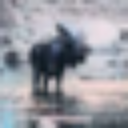

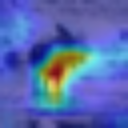

In [21]:
(x_train_new, y_train_new), (_, _) = cifar10.load_data()
image_number=9010
print(y_train_new[image_number])
class_val, sup_img=display_gradcam(x_train_new[image_number])


In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
Learning rate:  0.001
390/390 [==============================] - 76s 196ms/step - loss: 2.1921 - acc: 0.4384 - val_loss: 2.0952 - val_acc: 0.4329

Epoch 00001: val_acc improved from -inf to 0.43290, saving model to /content/saved_models/cifar10_ResNet38v2_model.001.h5
Epoch 2/50
Learning rate:  0.001
390/390 [==============================] - 64s 165ms/step - loss: 1.6950 - acc: 0.5687 - val_loss: 1.5942 - val_acc: 0.5971

Epoch 00002: val_acc improved from 0.43290 to 0.59710, saving model to /content/saved_models/cifar10_ResNet38v2_model.002.h5
Epoch 3/50
Learning rate:  0.001
390/390 [==============================] - 64s 165ms/step - loss: 1.4564 - acc: 0.6314 - val_loss: 1.6520 - val_acc: 0.5745

Epoch 00003: val_acc did not improve from 0.59710
Epoch 4/50
Learning rate:  0.001
390/390 [==============================] - 64s 164ms/step - loss: 1.3206 - acc: 0.6663 - val_loss: 1

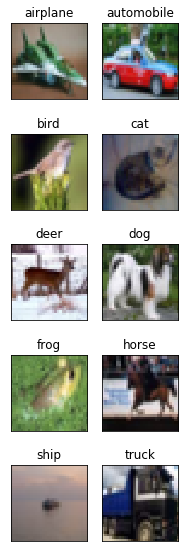

In [14]:
########################### Code borrowed from EIP4 Session2/3 #################
import time
import matplotlib.pyplot as plt
import numpy as np
rand_seed_val = 11080
np.random.seed(rand_seed_val)

% matplotlib inline
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
(x_train_new, y_train_new), (_, _) = cifar10.load_data()

num_classes = len(np.unique(y_train_new))
fig = plt.figure(figsize=(3,20))
for i in range(num_classes):
    ax = fig.add_subplot(10, 2, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train_new[:]==i)[0]
    features_idx = x_train_new[idx,::]
    img_num = np.random.randint(features_idx.shape[0])

    #predicted_class, gradcam_img = display_gradcam(features_idx[img_num])
    im = features_idx[img_num]
    #im2 = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
    #plt.imshow(gradcam_img)
plt.show()

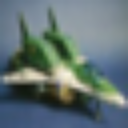

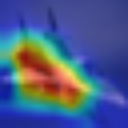

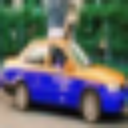

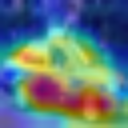

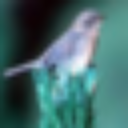

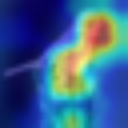

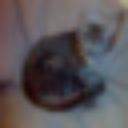

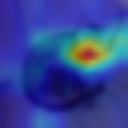

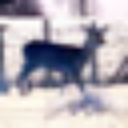

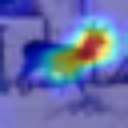

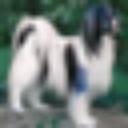

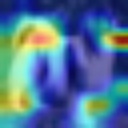

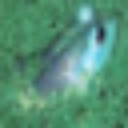

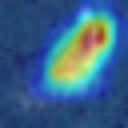

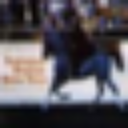

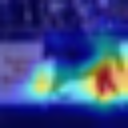

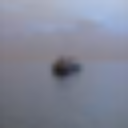

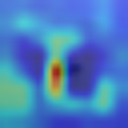

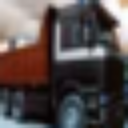

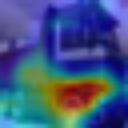

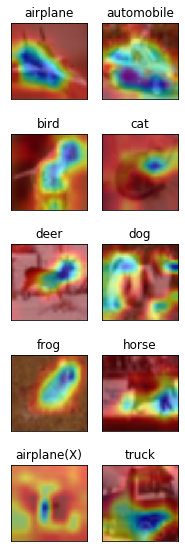

The images marked with (X) represents misclassification


In [19]:
import time
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(rand_seed_val)

% matplotlib inline
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
num_classes = len(np.unique(y_train_new))
fig = plt.figure(figsize=(3,20))
for i in range(num_classes):
    ax = fig.add_subplot(10, 2, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train_new[:]==i)[0]
    features_idx = x_train_new[idx,::]
    img_num = np.random.randint(features_idx.shape[0])

    predicted_class, gradcam_img = display_gradcam(features_idx[img_num])
    im = features_idx[img_num]
    #im2 = features_idx[img_num]
    title = class_names[predicted_class]
    
    if (predicted_class != i):
        title+="(X)"
    #plt.imshow(im)
    ax.set_title(title)
    plt.imshow(gradcam_img)
plt.show()
print("The images marked with (X) represents misclassification")

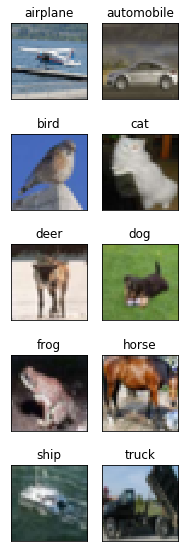

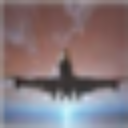

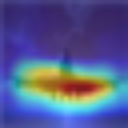

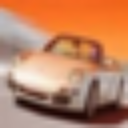

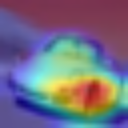

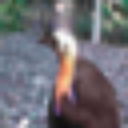

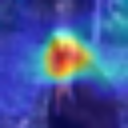

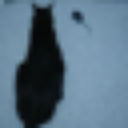

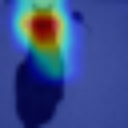

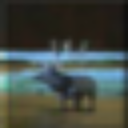

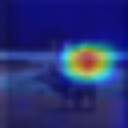

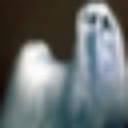

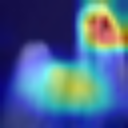

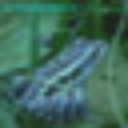

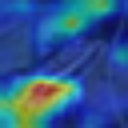

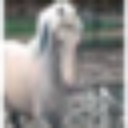

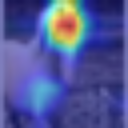

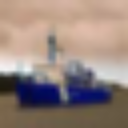

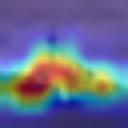

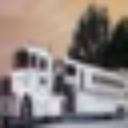

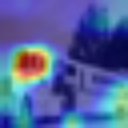

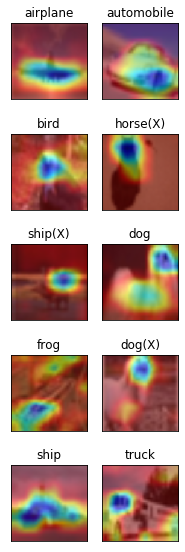

In [22]:
import time
import matplotlib.pyplot as plt
import numpy as np
rand_seed_val = 9080
np.random.seed(rand_seed_val)

% matplotlib inline
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
(x_train_new, y_train_new), (_, _) = cifar10.load_data()

num_classes = len(np.unique(y_train_new))
fig = plt.figure(figsize=(3,20))
for i in range(num_classes):
    ax = fig.add_subplot(10, 2, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train_new[:]==i)[0]
    features_idx = x_train_new[idx,::]
    img_num = np.random.randint(features_idx.shape[0])

    #predicted_class, gradcam_img = display_gradcam(features_idx[img_num])
    im = features_idx[img_num]
    #im2 = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
    #plt.imshow(gradcam_img)
plt.show()


fig = plt.figure(figsize=(3,20))
for i in range(num_classes):
    ax = fig.add_subplot(10, 2, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train_new[:]==i)[0]
    features_idx = x_train_new[idx,::]
    img_num = np.random.randint(features_idx.shape[0])

    predicted_class, gradcam_img = display_gradcam(features_idx[img_num])
    im = features_idx[img_num]
    #im2 = features_idx[img_num]
    title = class_names[predicted_class]
    
    if (predicted_class != i):
        title+="(X)"
    #plt.imshow(im)
    ax.set_title(title)
    plt.imshow(gradcam_img)
plt.show()